## Notes

These raw notes may provide some insights. In this raw form, they were not used for development, though.

## Linear algebra for Numerov's method

We aim to solve the special second-order differential equations

$$
\frac{d^2 y}{dx^2} = f(x,y), \quad \mathrm{with} \quad y(a) = y_0 \quad \mathrm{and} \quad y(a) = y'_0
$$

[Numerov's method](https://en.wikipedia.org/wiki/Numerov%27s_method) gives the following recurrence relation

$$ 
y_{n+1} - 2 y_n + y_{n-1} = \frac{h^2}{12} (f_{n+1} + 10 f_n + f_{n-1}) + \mathcal{O} (h^6)\,.
$$
It achieves order-4 accuracy. This is an implicit linear multistep method, which reduces to the explicit method given above if $f$ is linear in $y $ by setting 

$$ f(x,y) = - g(x) y(x) + s(x)\,.$$ 

In that case, the differential equation takes on this form:
$$
 \frac{d^2 y}{dx^2} = - g(x) y(x) + s(x).
$$
The three values of $ y_{n-1}, y_n, y_{n+1} $ taken at three equidistant points $ x_{n-1}, x_n, x_{n+1} $ are related as follows:

$$
y_{n+1} \left(1 + \frac{h^2}{12} g_{n+1}\right) = 2 y_n \left(1 - \frac{5 h^2}{12} g_n\right) - y_{n-1} \left(1 + \frac{h^2}{12} g_{n-1}\right) + \frac{h^2}{12} (s_{n+1} + 10 s_n + s_{n-1}) + \mathcal{O}(h^6),
$$
where $y_n = y(x_n)$, $g_n = g(x_n) $, $ s_n = s(x_n) $, and $ h = x_{n+1} - x_n $.

Let's define

$$
K_n(\xi) = 1 + \xi \frac{h^2}{12} g_{n}
$$

and then rewrite Numerov's relation for $n \geq 1$:

$$ \boxed{
y_{n+1} K_{n+1}(1) - 2 y_n K_{n}(-5) + y_{n-1}K_{n-1}(1) = \frac{h^2}{12} (s_{n+1} + 10 s_n + s_{n-1})}
$$

Given $y_0$ and $y_1$, we can express this relation as the linear system (i.e., matrix equation) $\mathbf{A} \vec{y} = \vec{s}$, with $\vec{y} = (y_0, y_1, y_2, \ldots, y_N)$ and

$$
\mathbf{A} = 
\begin{bmatrix}
    1      &            &            &            &        &              &                &    \\
    0      &  1         &            &            &        &              &                &    \\
    K_0(1) & -2 K_1(-5) & K_2(1)     &            &        &              &                &    \\ 
           & K_1(1)     & -2 K_2(-5) & K_3(1)     &        &              &                &   \\ 
           &            & K_2(1)     & -2 K_3(-5) & K_4(1) &              &                &  \\ 
           &            &            &            & \ddots &              &                &   \\
           &            &            &            &        &  K_{N-2}(1)  & -2 K_{N-1}(-5) & K_N(1)  \\
    \end{bmatrix}
$$

$$
\vec{s} = 
\begin{bmatrix}
y_0\\
y_1\\
\frac{h^2}{12} (s_2 + 10 s_1 + s_0)\\
\frac{h^2}{12} (s_3 + 10 s_2 + s_1)\\
\vdots\\
\frac{h^2}{12} (s_N + 10 s_{N-1} + s_{N-2})
\end{bmatrix}
$$


It might make sense to reduce the dimension of the matrix by explicity setting $y_0$. The result is, for the above case, the system $\mathbf{\tilde{A}} \vec{\tilde{y}} = \vec{\tilde{s}}$, with the ($N-1 \times N-1$) matrix: 

\begin{align}
\mathbf{\tilde{A}} &= 
\begin{bmatrix}
        K_2(1) &  &  &   &   & & &   \\ 
            -2 K_2(-5) & K_3(1) &   &   & & &   \\ 
                K_2(1) & -2 K_3(-5) & K_4(1) & & & & & \\ 
                &   & \ddots &  & & & &   \\
                &   &   &   &   &  K_{N-2}(1)  & -2 K_{N-1}(-5) & K_N(1)  \\
    \end{bmatrix}\\
\vec{\tilde{s}} &= 
\begin{bmatrix}
\frac{h^2}{12} (s_2 + 10 s_1 + s_0) - K_0(1)y_0 + 2 K_1(-5) y_1\\
\frac{h^2}{12} (s_3 + 10 s_2 + s_1) - K_1(1)y_1 \\
\vdots\\
\frac{h^2}{12} (s_N + 10 s_{N-1} + s_{N-2})
\end{bmatrix}
\end{align}
and $\vec{\tilde{y}} = (y_2, \ldots, y_N)$. This (reduced) matrix has the same $(l,u, B)$ as before. 

How to determine $y_1$ to start Numerov's method? We will discuss this important question in the next section.

## Implementation

In this subsection, we discuss the steps of the Numerov method in our implementation. We discuss both the general and the affine case.

### Matrix equation of Numerov's method

Now, we take advantage of the affine decompositions of $g(x)$ and $s(x)$. Let's consider the matrix first. We can write the matrix in diagonal ordered form, which is the input for `np.linalg.solve_banded()`, as follows:

$$
\begin{bmatrix} 
K_2(1) & K_3(1) & \cdots & K_{N-1}(1) & K_N(1)\\
-2K_2(-5) & -2K_3(-5) & \cdots & -2K_{N-1}(-5) & *\\
K_2(1) & K_3(1) & \cdots & * & *\\
\end{bmatrix}_{ij}
= 
\underbrace{
\begin{bmatrix}
1 \\ -2 \\ 1
\end{bmatrix}
\begin{bmatrix}
1 & 1 & \cdots
\end{bmatrix}}_{=B\times N-1}
+ \frac{h^2}{12}
\sum_k
\underbrace{
\left(
\begin{bmatrix} 
1\\10\\1
\end{bmatrix}_i
\begin{bmatrix}
g_2^{(0)} & g_2^{(1)} & g_2^{(2)} & \cdots \\
g_3^{(0)} & g_3^{(1)} & g_3^{(2)} & \cdots \\
g_4^{(0)} & g_4^{(1)} & g_4^{(2)} & \cdots \\ 
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}_{jk}
\right)
}_{=\mathcal{T}_{ijk}}
\begin{bmatrix}
\theta_0\\ \theta_1 \\ \vdots
\end{bmatrix}_k
$$

The values marked by $*$ are abitrary. For simplicity, we set them explictly, but we could set them to zero as a (simple) postprocessing step. Again, the terms in parenthesis can be prestored (e.g., using `np.einsum()`). See [Common operations in this notation](https://en.wikipedia.org/wiki/Einstein_notation#Common_operations_in_this_notation) as a refresher on the Einstein sum convention.

Next, we decompose the right-hand side vector:

\begin{align}
\vec{s} = 
\begin{bmatrix}
 - K_0(1)y_0 + 2y_1 \\
- y_1 \\
0\\
\vdots
\end{bmatrix}
+
 \frac{h^2}{12}
\begin{bmatrix}
 -10y_1  \\
 - y_1 \\
 0\\
\vdots
\end{bmatrix}
\begin{bmatrix}
g_1^{(0)} & g_1^{(1)} & g_1^{(2)} & \cdots 
\end{bmatrix}
\begin{bmatrix}
\theta_0\\ \theta_1 \\ \vdots
\end{bmatrix}
+
 \frac{h^2}{12}
 \underbrace{
\begin{bmatrix}
1 & 10 & 1 & & & \\
& 1 & 10 & 1 & & \\
&   &    &   & \ddots&
\end{bmatrix}
}_{(N-2) \times N}
\begin{bmatrix}
s_0^{(0)} & s_0^{(1)} & s_0^{(2)} & \cdots \\
s_1^{(0)} & s_1^{(1)} & s_1^{(2)} & \cdots \\
s_2^{(0)} & s_2^{(1)} & s_2^{(2)} & \cdots \\ 
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}
\begin{bmatrix}
\theta_0\\ \theta_1 \\ \vdots
\end{bmatrix}
\end{align}

This equation can be cast into the form: $\vec{s} = \vec{s}_0 (y_1,y_2) + S (y_1,y_2)\vec{\theta}$, where only the first two components of $\vec{s}_0$ are non-zero so that not the entire vector needs to be added to the second term. Alternatively, one could also use this form: $\vec{s} = \left(\vec{s}_0 (y_1,y_2) + S\right)\vec{\theta}$.

### Emulator equations

For the left-hand side of the emulator equation, we need to carry out the reduction and projection, $X^\intercal A X
$. To this end, we need the full matrix $\mathbf{A}$ rather than its diagonal ordered form (see above):

$$
\mathbf{A} = 
\begin{bmatrix}
    1 &  0 &  &   &   & & &   \\ 
    -2  & 1 & 0  &   & & &   \\ 
        1 & -2  & 1 & & & & & \\ 
        &   & \ddots &  & & & &   \\
        &   &   &   &   &  1  & -2  & 1
\end{bmatrix}
+
\frac{h^2}{12}
\sum_k
\underbrace{
    \left(
\begin{bmatrix}
1 &  0 &  &   &   & & &   \\ 
10 & 1 & 0  &   & & &   \\ 
1 & 10 & 1 & & & & & \\ 
    &   & \ddots &  & & & &   \\
    &   &   &   &   &  1  & 10 & 1 
\end{bmatrix}_{ij}

\begin{bmatrix}
g_3^{(0)} & g_3^{(1)} & g_3^{(2)} & \cdots \\
g_4^{(0)} & g_4^{(1)} & g_4^{(2)} & \cdots \\
g_5^{(0)} & g_5^{(1)} & g_5^{(2)} & \cdots \\ 
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}_{jk}
\right)
}_{\mathcal{=T_{ijk}}}
\begin{bmatrix}
\theta_0\\ \theta_1 \\ \vdots
\end{bmatrix}_k
$$

The matrix decomposition in terms of a diagonal matrix is optional. Hence, we can write $\mathbf{A}_{ij} = (\mathbf{A}_0)_{ij} + (\sum_k \mathcal{T}_{ijk} \theta_k)_{ij}$. 

The result of $X^\intercal A X$ has two terms:

* The first term is straightforward to evaluate since it involves the constant piece of $\mathbf{A}$.
* The second term involves a rank-3 tensor. We can write the components of the result as:

\begin{align}
(X^\dagger A X)_{ij} &=  (X^\dagger A_0 X)_{ij} + \sum \limits_{mlk} (X^\dagger)_{im} \mathcal{T}_{mlk} \theta_k X_{lj}\\
&= (X^\dagger A_0 X)_{ij} +\sum_k \left[\sum \limits_{ml} X_{mi}^* \mathcal{T}_{mlk} X_{lj}\right]_{ijk} \theta_k
\end{align}

Again, we use `np.einsum()` for tensor contractions (using Einstein sum convention).

For the right-hand side of the emulator equation, we need to carry out the projection $X^\intercal \vec{s}$. This is straightforward as each of the matrices in $\vec{s}$ (see above) just needs to be left multiplied by $X^\intercal$.

Note that the emulator prediction for $(y_0,y_1,y_2)$ are guaranteed to match those of the FOM. Hence, the emulated results will always abide by the initial conditions. This is good and bad news at the same time. 

The **good news** is that accurate initial conditions is crucial for overall accurate results. Also the reduced order model is supposed to live in the subspace where the initial conditions are fulfilled in the chosen approximation.

<font color=red> <b>
The bad news is that we can prestore less. But that's ok because what we can't prestore lives in a two-dimensional space, only affecting the first two components of the emulator equations.
</b> </font>

### Error estimates

#### Prestoring the error (scalar)

Let's discuss error estimates: We define the residual (in the full space)

$$
R = A \tilde{x} - s
$$

with $\tilde{x} = X \vec{\theta}$ being the solution in the reduced space. For high-fidelty calculations one has $R\equiv 0$. We seek after an error estimate that can be computed in the reduced space. One approach is decomposing the error as follows:

\begin{align}
\epsilon^2 \equiv R^\dagger R &= (A \tilde{x} - s)^\dagger (A \tilde{x} - s)\\
&= \tilde{x}^\dagger A^\dagger A\tilde{x} \\
&\quad - \underbrace{\left[\tilde{x}^\dagger A^\dagger s + (\tilde{x}^\dagger A^\dagger s)^\dagger\right]}_{= 2\operatorname{\mathbb{R}e}(\tilde{x}^\dagger A^\dagger s)}\\
&\quad+ s^\dagger s
\end{align}

One has to be careful with complex-valued problems, where instead of the transpose ($\intercal$) one has the hermitian-conjugate ($\dagger$). One also has to be careful with round off errors, which can render $\epsilon^2 < 0$.

The goal is then to minimze $\epsilon \geq 0$ by placing iteratively snapshots at locations of maximum error in the parameter space of the potential.

One issue is that both $A = A(\theta)$ and $b = b(\theta)$.

Another issue with this formulation is that we still have order-N operations. The solution is use the affine decomposition of the potential, which propagates through $A$ and $b$. The error $\epsilon \geq 0$ should be a polynomial of order of the number of snapshots in each dimension of the parameter space. Newton-Raphson could be used to find the location of maximum error if needed. The gradient with respect to the parameters can be computed analytically. Another option is automatic differentiation together with the Adam optimizer, e.g., as implemented in Google JAX. 

However, the coefficient vector of the ROM also depends nonlinearly on the parameter vector, which makes the optimization more complicated.

**How do we define the break condition for the greedy iteration?** The estimated error is (at best!) approximatively proportional to the real error. 

To construct an efficient error estimator in the online stage, we prestore all projections in form a tensors in the offline stage. This can be done as described in the following.

Let's recall: we can write $\vec{s} = \vec{s}_0 + S \vec{\theta}$, $A_{ij} = (A_0)_{ij} + (\sum_k \mathcal{T}_{ijk} \theta_k)_{ij}$, and $\tilde{x} = X c$. Note that the coefficient vector $c = c(\theta)$.

Hence, we find for these scalar terms the following.

The **first term** evaluates to:

\begin{align}
\tilde{x}^\dagger A^\dagger A\tilde{x} &= c^\dagger X^\dagger (A^\dagger A) X c\\
\left(X^\dagger A^\dagger A X\right)_{ij} &= \left(X^\dagger A_0^\dagger A_0 X \right)_{ij} 
+ \left((X^\dagger)_{ik} (A_0^\dagger)_{kl} \mathcal{T}_{lma} \theta_a X_{mj}\right)_{ij}
+ \left((X^\dagger)_{ik} \mathcal{T}_{lka}^* \theta_a^* (A_0)_{lm} X_{mj}\right)_{ij} 
+ \left((X^\dagger)_{ik} \mathcal{T}_{lka}^* \theta_a^* \mathcal{T}_{lmb} \theta_b X_{mj}\right)_{ij}  \\
&= \left( X^\dagger A_0^\dagger A_0 X \right)_{ij} 
+ \left[ \sum_a \left( \sum_{klm} (X^\dagger)_{ik} (A_0^\dagger)_{kl} \mathcal{T}_{lma}  X_{mj}\right)_{ija}  \theta_a + \mathrm{h.c.} \right]_{ij}
+ \sum_{ab} \left( \sum_{klm} (X^\dagger)_{ik} \mathcal{T}_{lka}^*  \mathcal{T}_{lmb} X_{mj}\right)_{ijab} \theta_a^* \theta_b
\end{align}

The rank-4 tensor has the shape $(n_s^2 \times n_\theta^2)$, where $n_s$ is the number of snapshots and $n_\theta$ the number of free parameters. For $(n_s=20, n_\theta=25)$, one thus has $250,000$ (complex-valued) tensor elements to prestore. In memory: $250,000 \times 2 \times 8 \, \mathrm{bytes} = 4\, \mathrm{Mb}$, so not at all a memory issue.

The **second term** evaluates to (for simplicity we evaluate the complex conjugated term):

\begin{align}
(\tilde{s}^\dagger A \tilde{x}) &= \sum \limits_{ijk}\left( s_0^\dagger + \theta^\dagger S^\dagger  \right)_{k} \left(A_0 + \sum \mathcal{T}_{kia} \theta_a \right)_{ki} X_{ij} c_{j}\\
&= (s_0^\dagger)_k (A_0)_{ki}  X_{ij} c_{j} 
+ (s_0^\dagger)_k \sum_a \mathcal{T}_{kia} \theta_a   X_{ij} c_{j}
+ \sum_b (S^\dagger)_{bk} \theta_b^* (A_0)_{ki} X_{ij} c_{j}
+ \sum_{ab} (S^\dagger)_{bk} \theta_b^* \mathcal{T}_{kia} \theta_a  X_{ij} c_{j}\\
&= (s_0^\dagger)_i \left[ \sum_l (A_0)_{il} X_{lj} \right]_{ij} c_{j} 
+ (s_0^\dagger)_k \sum_{aj} \left[ \sum_{i} \mathcal{T}_{kia}   X_{ij}  \right]_{ajk} \theta_a  c_{j}
+  \sum_{jb} \left[ \sum_{ik}  (S^\dagger)_{bk}  (A_0)_{ki}  X_{ij}  \right]_{bj} c_{j} \theta_b^*
+  \sum_{abj} \left[ \sum_{ik} (S^\dagger)_{bk} \mathcal{T}_{kia}   X_{ij} \right]_{baj} \theta_a \theta_b^* c_{j}
\end{align}

In the last step, we used that the parameter vector is real in our cases, so $\theta^* = \theta$. The terms in brackets can be prestored. Tensor reduction using `np.einsum`.

**Note that $s_0 = s_0(\theta)$, so it cannot be prestored. However, it's just a length-2 vector.**

The **third term** evaluates to:

\begin{align}
s^\dagger s &= s_0^\dagger s_0 + s_0^\dagger S \vec{\theta} + (s_0^\dagger S \vec{\theta})^\dagger + \vec{\theta}^\dagger S^\dagger S \vec{\theta}\\
&= s_0^\dagger s_0 + 2\operatorname{\mathbb{R}e} \left( s_0^\dagger S \vec{\theta} \right) + \vec{\theta}^\dagger S^\dagger S \vec{\theta}
\end{align}

Again, the two terms involving $s_0 = s_0(\theta)$ can only be partially prestored. 

#### Prestoring the residual vector

As already noted, one also has to be careful with round off errors, which can render $\epsilon^2 < 0$. To avoid those issues, we can reconstruct the residual vector and then compute any (desired) norm of the residual vector. This guarantees that $\epsilon^2 \geq 0$. 

Let's assume an affine parameter dependence for our linear system $A(\vec{\theta}) x = b(\vec{\theta}) $, where $A(\vec{\theta})$ is an $N \times N$ matrix and $b(\vec{\theta})$ a length-$N$ vector:

\begin{align}  
A(\vec{\theta}) &= \sum_{i}^{n_\theta} A_i \theta_i \\  
b(\vec{\theta}) &= \sum_{i}^{n_\theta} b_i \theta_i  
\end{align}  

Next, we write high-fidelity solutions in a matrix form, where $X$ (a $N \times n_b$ matrix) has the snapshot solutions in its columns. Then, we consider the residual for our reduced-basis approximation $x \approx X \vec{c}$, where $c$ is the coefficient vector:

\begin{align}  
R(\theta) &= A(\vec{\theta})  X \vec{c} - b(\vec{\theta}) \\
&= \sum_{i}^{n_\theta} \left[ A_i X \vec{c} - b_i \right] \vec{\theta}_i
\end{align}  

We are interested in $\varepsilon^2 = R^\dagger(\vec{\theta}) R(\vec{\theta}) \geqslant 0$. We can see that this residual $R(\theta)$ lives in the vector space spanned by the columns of all $A_i X$ and all vectors $b_i$. Hence, we compute the (matrix) components:
  
$$  
B_i = A_i X \quad \forall i \; \mathrm{separately}
$$  
  
Now, we create a block matrix from all $B_i$ (i.e., $N \times n_b$ matrices) by stacking them horizontally. In `numpy`, this can be done using the `hstack()` function. In addition, we stack the vectors $b_i$ to obtain the $N \times n_\theta(n_b+1)$ matrix.

$$
Y = \begin{bmatrix} B_1 & B_2 & \cdots & B_{n_\theta} & b_1 & b_2 & \cdots & b_{n_\theta}\end{bmatrix}
$$

Next, we orthnonormalize the vectors in the columns of $Y$, which contain the projection basis. This could be done using the modified Gram-Schmidt process, or using the (truncated) SVD. Note that $P = Y Y^\dagger$ has become an **orthogonal projector** onto the space of the residuals $R(\theta)$ for our RBM approximation. This implies the identities:

\begin{align}
P^2 &\equiv P\\
P \, R(\vec{\theta}) &\equiv R(\vec{\theta}) \quad \forall \vec{\theta}, \vec{c}\\
P^\dagger &\equiv P
\end{align}

Note that this does _not_ imply that $P = 1$ (identity matrix). Let's consider the projected residual vector:
  
\begin{align}  
    r(\vec{\theta}) &\equiv Y^\dagger R(\vec{\theta}) = Y^\dagger A(\vec{\theta}) X \vec{c} (\vec{\theta}) - Y^\dagger b(\vec{\theta})
\end{align}  

It is a length-$n_\theta(n_b+1)$ vector. Hence, it generally does not live in the reduced or full space but instead in an **"intermediate space"**! Truncated SVDs for orthonormalizations help reduce the dimension of this space.

Because $P = Y Y^\dagger$ is a projector (note that $X X^\dagger$ generally is _not_ an orthogonal projector onto the space of the residuals), we find that:

$$
r^\dagger(\theta) r(\theta) = R^\dagger(\theta) \underbrace{Y Y^\dagger R(\theta)}_{=R(\theta)} =  R^\dagger(\theta) R(\theta) \equiv \epsilon^2 
$$

That means the norms of the residual vector in the full and in the projected space are equivalent. Using the affine decomposition, the residual vector can be efficiently prestored:

\begin{align}
    r(\theta) &= Y^\dagger A(\theta) X c(\theta) - Y^\dagger b(\theta) \\
              &= \sum_{a}^{n_\theta} \left[ Y^\dagger A_a X \right] \,  c(\theta) \theta_k - \sum_{a}^{n_\theta} \left[Y^\dagger  b_a\right] \theta_a \\
  r_i(\theta) &= \sum_{al}  \underbrace{\sum_{jk} (Y^\dagger)_{ij} A_a^{(jk)} X_{kl}}_{=\mathcal{T}_{ial}} \,  c_l(\theta) \theta_a - \sum_{a} \underbrace{\sum_{j} (Y^\dagger)_{ij}  b_a^{(j)}}_{=\mathcal{T}_{ia}} \theta_a
\end{align}

#### Alternative emulator: Least-Squares Petrov-Galerkin projection
  
Instead of left-multiplying by $X^\dagger$, the linear system, one can multiply by $Y^\dagger$. This corresponds to the **Petrov-Galerkin projection**:

$$
\underbrace{Y^\dagger A(\theta) X}_{= (n_\theta(n_b+1)) \times n_b \, \mathrm{matrix}} c(\theta) = Y^\dagger b(\theta)  
$$

and then solve the reduced equations for $c(\theta)$ using a least-squares solver. This emulator minimizes the residual (i.e., the error) and is known in the literature as **Least-Squares Petrov-Galerkin (LSPG) ROM**. We can use the affine decomposition as follows:

\begin{align}
Y^\dagger A(\theta) X &= \sum_{i}^{n_\theta} Y^\dagger \underbrace{A_i X}_{=B_i} \theta_i \\
&= \sum_{i}^{n_\theta} \left[ Y^\dagger B_i \right] \theta_i 
\end{align}

This allows us to prestore the terms $Y^\dagger B_i$, for all $i$, in the offline stage, and then reconstruct the entire matrix efficiently in the online stage. 

Note that `scipy.linalg.lstsq()` supports multiple methods as opposed to the corresponding `numpy` implementation. **Both implementations return the needed residual vector $r(\theta)$**, so there is no need to compute it for the given the coefficient vector $\vec{c}$ following the approach discussed in the previous subsection. (For more details on solving the least-squares problem using the $QR$ decomposition, see, e.g., [here](https://www.math.kent.edu/~reichel/courses/intr.num.comp.1/fall09/lecture4/lecture4.pdf).)

This Petrov-Galerkin project can be understood differently (by building an emulator for the symmetric positive-definite (s.p.d.) matrix $A^\dagger A$ instead of $A$):

\begin{align}
A(\theta) Xc(\theta) &= b(\theta) \\
\underbrace{A^\dagger(\theta) A(\theta)}_{=\mathrm{s.p.d.\ matrix}} Xc(\theta) &= A^\dagger(\theta)b(\theta) \qquad \mathrm{(normal\ equation)} \\
\underbrace{\left[X^\dagger A^\dagger(\theta) A(\theta)X \right]}_{=\mathrm{s.p.d.\ matrix}} \, c(\theta) &= X^\dagger A^\dagger(\theta)b(\theta) \\
\end{align}

Here, $X^\dagger A^\dagger(\theta)$ corresponds to the Petrov-Galerkin projection. This system has the same least-squares solution as the one above (in this subsection). It has the advantage that the emulator matrix is s.p.d., which means it is invertible (albeit it may still be poorly conditioned) and thus may be **less susceptible to spurious singularities** (Kohn anomalies). 

Note that the underbraced matrices above are only s.p.d. if $A(\theta)$ is non-singular (which we assume from the beginning) and $X$ has linearly independent columns. Hence, we assume here and in the following that the snapshot matrix $X$ has been POD'ed. (See also page 15 in [here](http://www.seas.ucla.edu/~vandenbe/133A/lectures/ls.pdf).)

We can see that the two systems have the same least-squares solution as follows: We start from the Petrov-Galerkin projection above and left-multiply by the transposed (or daggered) matrix on the left-hand side. This results in the normal equation:

\begin{align}
X^\dagger A^\dagger ( Y  Y^\dagger ) A X c &= X^\dagger A^\dagger  ( Y Y^\dagger ) b \\
X^\dagger A^\dagger ( Y  Y^\dagger ) \underbrace{( A X c - b )}_{=R} &= 0 \\
X^\dagger A^\dagger ( A X c - b ) &= 0 \\
X^\dagger A^\dagger  A X c  = X^\dagger A^\dagger b
\end{align}

We have used that $Y Y^\dagger$ is an orthogonal projector onto the space of the residuals. The final equation is the emulator equation for the matrix $A^\dagger A$, which we wanted to show.

It would be interesting to compare this emulator with our previous emulator in terms of accuracy and speed up. This residual-based emulator is well-suited for greedy algorithm implementations.

#### Theoretical error bounds

One can derive **theoretical bounds** on the true error $|(\tilde{x}-x)|$ based on our estimate $\epsilon = |R|$ in the full space. These bounds are determine by the smallest and largest singular vector of the Numerov matrix $A$.

**Lower bound:**
$$
\epsilon = |A x - s| = | A(\tilde{x}-x)| \leq \underbrace{|A|}_{=\sigma_\mathrm{max}} |(\tilde{x}-x)| 
\Longleftrightarrow \frac{\epsilon}{\sigma_\mathrm{max}} \leq  |(\tilde{x}-x)|
$$

**Upper bound:**
$$
|\tilde{x}-x| = |A^{-1} R| \leq \underbrace{|A^{-1}|}_{=\sigma_\mathrm{min}^{-1}} \epsilon
\Longleftrightarrow  |(\tilde{x}-x)| \leq \frac{\epsilon}{\sigma_\mathrm{min}} 
$$

A conservative approach is to use the upper bound as the error estimate. For this approach, the smallest singular value is needed, which can be estimated, e.g., using the [**successive constraint method (SCM)**](https://nam11.safelinks.protection.outlook.com/?url=https%3A%2F%2Fwww.sciencedirect.com%2Fscience%2Farticle%2Fpii%2FS1631073X07003871&data=05%7C02%7Cdrischler%40ohio.edu%7C46350be3c79142903aa708dc316a1338%7Cf3308007477c4a70888934611817c55a%7C0%7C0%7C638439579044877550%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C0%7C%7C%7C&sdata=oaTQUn3EcWSVG%2Bp5Iw0pj7sn2brOg54izlrVZpN4%2B7s%3D&reserved=0). This method can give a lower bound for a new parameter value based on previously computed smallest singular values for other parameter values.

A different approach is the [**hierarchical posteriori error estimation (HPEE)**](https://nam11.safelinks.protection.outlook.com/?url=https%3A%2F%2Flink.springer.com%2Farticle%2F10.1007%2Fs10444-019-09675-z&data=05%7C02%7Cdrischler%40ohio.edu%7C46350be3c79142903aa708dc316a1338%7Cf3308007477c4a70888934611817c55a%7C0%7C0%7C638439579044900640%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C0%7C%7C%7C&sdata=kggKxqTepFj22p0LsYlwMMBcXKMCKPX8YWmbqFq44ho%3D&reserved=0), which computes  errors between different reduced models to estimate the true error. It may be less rigorous than the SCM.

### Schrödinger equation 

Now, let's investigate the radial Schroedinger equation to identify $g(x)$ and $s(x)$. We begin with the **homogeneous** case:

$$ 
\frac{d^2 u(r)}{dr^2} = \left(2\mu V(r) + \frac{l (l + 1)}{r^2} - \underbrace{2\mu E}_{=p^2} \right) u(r)  
$$

Note that we did not introduce an effective potential in the parenthesis. From this equation, we can deduce the function required by our Numerov method:

\begin{align}
g(r) &= p^2 -2\mu V(r) - \frac{l (l + 1)}{r^2} \\
s(r) &= 0
\end{align}

In addition, we have the trivial change of notation: $y(x) = u(r)$. In the affine case, we have:

\begin{align}
g(r) &= \underbrace{p^2 -2\mu V_\mathrm{const}(r) - \frac{l (l + 1)}{r^2}}_{=g_\mathrm{const}(r)} + \sum_a \underbrace{(-2\mu) V_a(r)}_{=g_a(r)} \theta_a \\
s(r) &= 0 \equiv S_\mathrm{const}(r) \equiv S_\theta(r)
\end{align}

Next, we consider the **inhomogeneous** case corresponding to Eq. (48) in the [BUQEYE Guide](https://arxiv.org/abs/2212.04912):

$$
[E - H] \ket{\chi} = V \ket{\phi} 
$$

where $\ket{\chi} = \ket{\psi} - \ket{\phi}$ is the scattered wave function and $\ket{\phi}$ the free wave function. In this case, we have

$$ 
\frac{d^2 \chi(r)}{dr^2} =- \left(p^2 -2\mu V(r) - \frac{l (l + 1)}{r^2} \right) \chi(r) + 2\mu V(r) \phi(r)
$$

Hence, we identify:

\begin{align}
g(r) &= p^2 -2\mu V(r) - \frac{l (l + 1)}{r^2} \\
s(r) &= 2 \mu V(r) \phi(r)
\end{align}

Note that $g(r)$ is the same as for the homogeneous Schroedinger equation (as expected). In the affine case, we have:

\begin{align}
g(r) &= \underbrace{p^2 -2\mu V_\mathrm{const}(r) - \frac{l (l + 1)}{r^2}}_{=g_\mathrm{const}(r)} + \sum_a \underbrace{(-2\mu) V_a(r)}_{=g_a(r)} \theta_a \\
s(r) &= \underbrace{2 \mu V_\mathrm{const}(r) \phi(r)}_{S_\mathrm{const}(r)} + \underbrace{2 \mu V_a  \phi(r)}_{=s_a(r)} \theta_a
\end{align} 

## Transforming low-energy constants (LECs)

The (Lagrangian) low-energery constants (LECs) $C_S, C_T,$ and $C_{1-7}$ were fit to NN phase shifts. In every partial wave only certain LECs contribute. In the following we give the partial 
wave decomposition for all relevant channels. We use spectroscopic LECs given in terms of $C_S, C_T,$ and $C_{1-7}$ as follows:

\begin{align}
d_{11}^{(np)} & =C_S^{(np)} + C_T \,,  \\
d_{22}^{(m_T)} & =C_S^{(m_T)}-3C_T \,, \quad m_T = \text{np}, \, \text{nn}, \, \text{pp}\\
d_{1} & =C_1-3C_2+C_3-3C_4 \,, \\
d_{2} & =C_6-3C_7 \,, \\
d_{3} & =C_1+C_2-3C_3-3C_4 \,, \\
d_{4} & =C_1+C_2+C_3+C_4 \,, \\
d_{5} & =C_1-3C_2-3C_3+9C_4 \,, \\
d_{6} & =\frac{1}{2} C_5 \,, \\
d_{7} & = C_6+C_7\,. 
\end{align}

Note that $C_S$ include isospin symmetry breaking effects. The authors defined:

$$
C_S^{(m_T)} = 
\begin{cases}
C_S  & m_T = \text{np}\\
C_S + C_{NN} & m_T = \text{nn}\\
C_S + C_{PP} & m_T = \text{pp}
\end{cases}
$$

Note the order in which the isospin channels appear. With isospin breaking affects, we can write the linear system as:

$$
\begin{pmatrix}
d_{11}^{(np)} \\
d_{22}^{(np)}\\
d_{22}^{(nn)}\\
d_{22}^{(pp)}\\
d_{1} \\
d_{2} \\
d_{3} \\
d_{4} \\
d_{5} \\
d_{6} \\
d_{7} 
\end{pmatrix}
= 
\begin{bmatrix}
1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & -3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 1 & 0 & -3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 1 & -3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & -3 & 1 & -3 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & -3 \\
0 & 0 & 0 & 0 & 1 & 1 & -3 & -3 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & -3 & -3 & 9 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac{1}{2} & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1
\end{bmatrix}
\begin{pmatrix}
C_{S} \\
C_{NN}\\
C_{PP}\\
C_{T}\\
C_{1} \\
C_{2} \\
C_{3} \\
C_{4} \\
C_{5} \\
C_{6} \\
C_{7} 
\end{pmatrix}
$$

Only the terms with $d_{11}$ and $d_{22}$ are leading order (LO) LECs, the others are next-to-leading (NLO) LECs.
We define the following `numpy` array to represent this invertible linear transformation (i.e., matrix)

In [1]:
import numpy as np
trafo = np.array([[1 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[1 , 0 , 0 , -3 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[1 , 1 , 0 , -3 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[1 , 0 , 1 , -3 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 1 , -3 , 1 , -3 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , -3 ],
[0 , 0 , 0 , 0 , 1 , 1 , -3 , -3 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 1 , 1 , 1 , 1 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 1 , -3 , -3 , 9 , 0 , 0 , 0 ],
[0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1/2 , 0 , 0 ],
[0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 1]])
np.linalg.det(trafo)

-2047.9999999999984

For the partial-wave-decomposed matrix elements for the NN contact interactions, the developers provide in their appendix the following expressions

\begin{align}
\bra{^1S_0}V_{\text{cont}}\ket{^1S_0}&= d_{22}\delta_{R_0}+(d_3-d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}  \\& \quad-(d_3-d_7) \, 16 \frac{r^6}{R_0^8}\delta_{R_0} \,,\\
\bra{^3S_1}V_{\text{cont}}\ket{^3S_1}&= d_{11}\delta_{R_0}+(d_1+ \frac{1}{3} d_2)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}  \\& \quad-(d_1+ \frac{1}{3} d_2)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}\,,\\
\bra{^3S_1}V_{\text{cont}}\ket{^3D_1}&= \bra{^3D_1}V_{\text{cont}}\ket{^3S_1} \\&= d_2 \frac{\sqrt{8}}{3}\, 8\frac{r^2}{R_0^4}\delta_{R_0}-d_2 \frac{\sqrt{8}}{3}\, 16\frac{r^6}{R_0^8}\delta_{R_0}\,,  \\
\bra{^3D_1}V_{\text{cont}}\ket{^3D_1}&= d_{11}\delta_{R_0}-(d_1- \frac{1}{3} d_2)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  \\& \quad + (d_1+ \frac{3}{5} d_6 +\frac{1}{15}d_2)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^1P_1}V_{\text{cont}}\ket{^1P_1}&= \,d_{22}\delta_{R_0}+(d_5- d_2)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}  \\& \quad -(d_5- d_2)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}\,,\\
\bra{^3P_0}V_{\text{cont}}\ket{^3P_0}&= d_{11}\delta_{R_0}-(d_4-d_7)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}   \\& \quad + (d_4+\frac{2}{5} d_6 -\frac{1}{5}d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^3P_1}V_{\text{cont}}\ket{^3P_1}&= d_{11}\delta_{R_0}-(d_4+d_7)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}   \\& \quad + (d_4+ \frac{1}{5} d_6 + \frac{3}{5} d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,, \\
\bra{^3P_2}V_{\text{cont}}\ket{^3P_2}&= d_{11}\delta_{R_0}-(d_4+ \frac{1}{5} d_7)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  \\& \quad + (d_4- \frac{1}{5} d_6 +\frac{7}{25} d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^3P_2}V_{\text{cont}}\ket{^3F_2}&= \bra{^3F_2}V_{\text{cont}}\ket{^3P_2} \\&= \, d_7 \sqrt{6}\frac{16}{5}\frac{r^2}{R_0^4}\delta_{R_0}-d_7 \sqrt{6}\frac{32}{5} \frac{r^6}{R_0^8}\delta_{R_0} \,,\\
\bra{^3F_2}V_{\text{cont}}\ket{^3F_2}&= d_{11}\delta_{R_0}-(d_4- \frac{1}{5} d_7)  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  \\& \quad + (d_4+\frac{4}{5} d_6 +\frac{3}{25} d_7)\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,.
\end{align}

Note that the labels specifying the isospin channels are omitted for brevity. In channels with $T=1$, which we can identify by the requirement that $L + S + T$ has to be odd (Pauli principle), we have 3 isospin projection channels. In channels with $T=0$, we have only 1 isospin projection channel.

Now, let's refactor these equations a bit for our purpose:

\begin{align}
\bra{^1S_0}V_{\text{cont}}\ket{^1S_0} &= d_{22}\delta_{R_0}+ \underbrace{(d_3-d_7)}_{=D_{1S_0}} \left[ 20 \frac{r^2}{R_0^4}\delta_{R_0}  - \, 16 \frac{r^6}{R_0^8}\delta_{R_0} \right] \,,\\
\bra{^3S_1}V_{\text{cont}}\ket{^3S_1} &= d_{11}\delta_{R_0} + \underbrace{(d_1+ \frac{1}{3} d_2)}_{=D_{3S_1}} \left[ 20 \frac{r^2}{R_0^4}\delta_{R_0} -  16 \frac{r^6}{R_0^8}\delta_{R_0} \right] \,,\\
\bra{^3S_1}V_{\text{cont}}\ket{^3D_1} &= \bra{^3D_1}V_{\text{cont}}\ket{^3S_1} \\&= d_2 \left[ \frac{\sqrt{8}}{3}\, 8\frac{r^2}{R_0^4}\delta_{R_0}- \frac{\sqrt{8}}{3}\, 16\frac{r^6}{R_0^8}\delta_{R_0} \right] \,,  \\
\bra{^3D_1}V_{\text{cont}}\ket{^3D_1}&= d_{11}\delta_{R_0}-\underbrace{(d_1- \frac{1}{3} d_2)}_{=D_{^3D_1}}  \, 16 \frac{r^6}{R_0^8}\delta_{R_0} + \underbrace{(d_1+ \frac{3}{5} d_6 +\frac{1}{15}d_2) }_{=D_{^3D_1}'} \, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^1P_1}V_{\text{cont}}\ket{^1P_1} &= \,d_{22}\delta_{R_0}+ \underbrace{(d_5- d_2)}_{=D_{^1P_1}}\left[ 20 \frac{r^2}{R_0^4}\delta_{R_0} - 16 \frac{r^6}{R_0^8}\delta_{R_0} \right]\,,\\
\bra{^3P_0}V_{\text{cont}}\ket{^3P_0} &= d_{11}\delta_{R_0}- \underbrace{(d_4-d_7)}_{=D_{^3P_0}}  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  + \underbrace{(d_4+\frac{2}{5} d_6 -\frac{1}{5}d_7)}_{=D_{^3P_0}'}\, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^3P_1}V_{\text{cont}}\ket{^3P_1}&= d_{11}\delta_{R_0}- \underbrace{(d_4+d_7)}_{=D_{^3P_1}}  \, 16 \frac{r^6}{R_0^8}\delta_{R_0}   + \underbrace{(d_4+ \frac{1}{5} d_6 + \frac{3}{5} d_7)}_{=D_{^3P_1}'} \, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,, \\
\bra{^3P_2}V_{\text{cont}}\ket{^3P_2}&= d_{11}\delta_{R_0}- \underbrace{(d_4+ \frac{1}{5} d_7)}_{=D_{^3P_2}} \, 16 \frac{r^6}{R_0^8}\delta_{R_0}  + \underbrace{(d_4- \frac{1}{5} d_6 +\frac{7}{25} d_7)}_{=D_{^3P_2}'} \, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,,\\
\bra{^3P_2}V_{\text{cont}}\ket{^3F_2}&= \bra{^3F_2}V_{\text{cont}}\ket{^3P_2} \\&= \, d_7 \left[ \sqrt{6}\frac{16}{5}\frac{r^2}{R_0^4}\delta_{R_0} -  \sqrt{6}\frac{32}{5} \frac{r^6}{R_0^8}\delta_{R_0} \right] \,,\\
\bra{^3F_2}V_{\text{cont}}\ket{^3F_2}&= d_{11}\delta_{R_0}- \underbrace{(d_4- \frac{1}{5} d_7)}_{=D_{^3F_2}}  \, 16 \frac{r^6}{R_0^8}\delta_{R_0} + \underbrace{(d_4+\frac{4}{5} d_6 +\frac{3}{25} d_7)}_{=D_{^3F_2}'} \, 20 \frac{r^2}{R_0^4}\delta_{R_0}\,.
\end{align}

Our goal is to train different emulators in different partial wave channels. To this end, we train

Now, we define the transform that renders removes all linear combinations in these expressions:

$$
\begin{pmatrix}
d_{11}^{(np)} \\
d_{22}^{(np)}\\
d_{22}^{(nn)}\\
d_{22}^{(pp)}\\
D_{^1S_0}\\
D_{^3S_1}\\
d_{2} \\
D_{^3D_1}\\
D_{^3D_1}'\\
D_{^1P_1}\\
D_{^3P_0}\\
D_{^3P_0}'\\
D_{^3P_1}\\
D_{^3P_1}'\\
D_{^3P_2}\\
D_{^3P_2}'\\
d_{7} \\
D_{^3F_2}\\
D_{^3F_2}'
\end{pmatrix}
= 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & -1 \\
0 & 0 & 0 & 0 & 1 & \frac{1}{3} & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & \frac{1}{3} & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & \frac{1}{15} & 0 & 0 & 0 & \frac{3}{5} & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & \frac{2}{5} & -\frac{1}{5} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & -1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & \frac{1}{5} & \frac{3}{5} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & -\frac{1}{5} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & -\frac{1}{5} & \frac{7}{25} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & \frac{1}{5} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & \frac{4}{5} & \frac{3}{25} 
\end{bmatrix}
\begin{pmatrix}
d_{11}^{(np)} \\
d_{22}^{(np)}\\
d_{22}^{(nn)}\\
d_{22}^{(pp)}\\
d_{1} \\
d_{2} \\
d_{3} \\
d_{4} \\
d_{5} \\
d_{6} \\
d_{7} 
\end{pmatrix}
$$

**This system is overdetermined (i.e., rectangular) since we are using local chiral interactions.** That is ok since we will sample in the spectroscopic ($d$'s) or Lagrangrian ($C$'s) and then obtain the set of LECs above, in whose parameter space the emulators in each partial wave are trained on. In other words, we don't need to invert this linear system. 

Here's the `numpy` version of this matrix:

In [2]:
import numpy as np
lin_comb = np.array(
    [[1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , -1 ],
     [0 , 0 , 0 , 0 , 1 , 1/3 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 0 , -1 , 1/3 , 0 , 0 , 0 , 0 , 0 ],
     [0 , 0 , 0 , 0 , 1 , 1/15 , 0 , 0 , 0 , 3/5 , 0 ],
     [0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , 1 , 0 , 0 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , 1 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 2/5 , -1/5 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , -1 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 1/5 , 3/5 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , -1/5 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , -1/5 , 7/25 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , -1 , 0 , 0 , 1/5 ],
     [0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 4/5 , 3/25]
])
lin_comb.shape

(19, 11)

The combined transformation matrix from the ($C_S,C_T,\ldots)$ notation to the linear combinations in the expressions is then given by: `lin_comb @ trafo`, which has the shape

In [3]:
(lin_comb @ trafo).shape

(19, 11)

As mentioned, the linear system above is overdetermined (by construction). We can select a subset of the rows to render the system square and invertible. We choose here the subset of rows that maximizes the absolute value of the determinant of the remaining (square) system. We call this subset the non-redundant rows (or constraints) and the remaining the redundant rows:

In [4]:
from itertools import combinations
all_rows = range(19)
idxs = list(combinations(all_rows, r=11))
res = [np.linalg.det(lin_comb[row_idxs,:]) for row_idxs in idxs]
nonredundant_rows = list(idxs[np.argmax(np.abs(res))])  # could also use argmax()
redundant_rows = list(set(all_rows) - set(nonredundant_rows))
print("indices of the nonredundant rows (choice): ", nonredundant_rows)
print("indices of the corresponding redundant rows:", redundant_rows)
print("determinant of neduced matrix:", np.linalg.det(lin_comb[nonredundant_rows,:]))


indices of the nonredundant rows (choice):  [0, 1, 2, 3, 4, 5, 6, 9, 10, 12, 18]
indices of the corresponding redundant rows: [7, 8, 11, 13, 14, 15, 16, 17]
determinant of neduced matrix: 1.6


In addition, we also deal with (up to 3) different constant terms in the potential, $V_\mathrm{const}^{(m_T)}$, corresponding to the isospin channels. However, in a given channel, such as $^1S_0^{(\mathrm{np})}$, only one $V_\mathrm{const}^{(m_T)}$ contributes.

## Affine version in momentum space

We also modified the source code provided by the developers in momentum space to provide an affine decomposition similar to the one in coordinate space. **This will be used in a future publication, so please don't use it.**

Here is how it works:

True

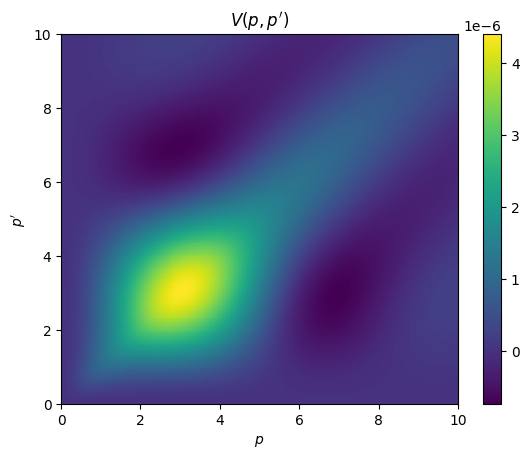

In [5]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")

import numpy as np
import matplotlib.pyplot as plt
from Potential import Potential, chiralms
from Channel import Channel

potentialArgs = {"label": "chiral", "kwargs": {"potId": 233}}
l = 0
channel = Channel(S=1, L=2, LL=2, J=1, channel=0)
potential = Potential(channel, **potentialArgs)

num_pts = 400
k_arr = np.linspace(0., 20., num_pts)
Vp = np.zeros((num_pts, num_pts))

import scipy.linalg as spla
for j, kk in enumerate(k_arr):
    for i, k in enumerate(k_arr):
        Vp[i, j] = chiralms(k, kk, channel, use_default_lec_values=True, **potentialArgs["kwargs"])
fig, ax = plt.subplots(1,1)
out = ax.pcolormesh(k_arr, k_arr, Vp) # , shading='gouraud')
# ax.imshow(Vp)
ax.set_xlabel("$p$")
ax.set_ylabel("$p'$")
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_title("$V(p,p')$")
_ = fig.colorbar(out)
# fig.savefig("chiral_momentum_space.png", dpi=200)
np.allclose(Vp, Vp.T)